In [2]:
using ArgParse
#using BSON
using Distributions
using Flux, Flux.Tracker, DiffEqFlux, DifferentialEquations
using Plots
using Pkg
Pkg.add("CSV")
using CSV

┌ Info: Recompiling stale cache file /Users/iancarter/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/iancarter/.julia/compiled/v1.1/DiffEqFlux/BdO4p.ji for DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1184


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [11]:
# Generate the data
nspiral = 1000
ntotal = 500
nsample = 100
start = 0.
stop = 6 * pi
noise_std = .3
a = 0.
b = .3

orig_trajs = permutedims(reshape(convert(Array{Float64,2}, CSV.read("latent_ode_data/orig_trajs.csv", header=false)), (nspiral, ntotal, 2)), [3, 2,1])
samp_trajs = permutedims(reshape(convert(Array{Float64,2}, CSV.read("latent_ode_data/samp_trajs.csv", header=false)), (nspiral, nsample, 2)), [3, 2,1])
orig_ts = convert(Array{Float64}, CSV.read("latent_ode_data/orig_ts.csv", header=false))
samp_ts = convert(Array{Float64}, CSV.read("latent_ode_data/samp_ts.csv", header=false))

┌ Warning: `convert(::Type{Array{T}}, df::AbstractDataFrame) where T` is deprecated, use `convert(Matrix{T}, df)` instead.
│   caller = top-level scope at In[11]:13
└ @ Core In[11]:13
┌ Warning: `convert(::Type{Array{T}}, df::AbstractDataFrame) where T` is deprecated, use `convert(Matrix{T}, df)` instead.
│   caller = top-level scope at In[11]:14
└ @ Core In[11]:14


100×1 Array{Float64,2}:
 0.0                 
 0.037774661165408334
 0.07554932233081667 
 0.113323983496225   
 0.15109864466163334 
 0.18887330582704168 
 0.22664796699245    
 0.26442262815785833 
 0.30219728932326667 
 0.339971950488675   
 0.37774661165408335 
 0.4155212728194917  
 0.4532959339849     
 ⋮                   
 3.3241701825559336  
 3.3619448437213415  
 3.39971950488675    
 3.4374941660521583  
 3.4752688272175667  
 3.513043488382975   
 3.5508181495483835  
 3.588592810713792   
 3.6263674718792     
 3.6641421330446082  
 3.7019167942100166  
 3.739691455375425   

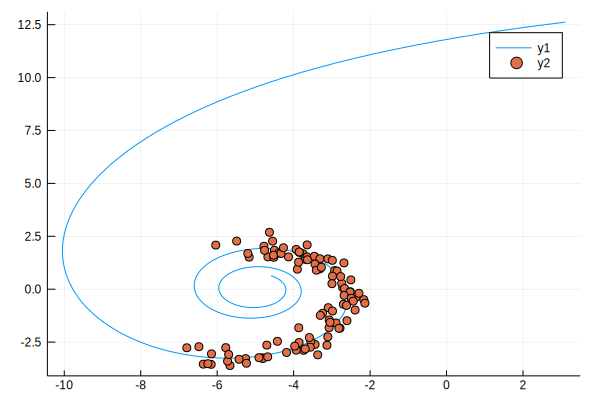

In [12]:
plot(orig_trajs[1,:,2], orig_trajs[2,:,2])
scatter!(samp_trajs[1,:,2], samp_trajs[2,:,2])

In [13]:
rands = convert(Array{Float64}, CSV.read("latent_ode_data/1kx1k_randn.csv", header=false))

┌ Warning: `convert(::Type{Array{T}}, df::AbstractDataFrame) where T` is deprecated, use `convert(Matrix{T}, df)` instead.
│   caller = top-level scope at In[13]:1
└ @ Core In[13]:1


1000000×1 Array{Float64,2}:
  0.8502274881004251 
  0.670630579226953  
 -0.4815355401196697 
  1.3689761413731467 
  1.8074524907651115 
  1.9676152915423097 
 -0.2883367568962394 
  1.8797880947184675 
  0.48382913958495416
  0.9485158476445831 
  0.6756569708085894 
  0.6802399217727957 
 -0.6958639673519409 
  ⋮                  
  1.0659902567614488 
  0.15081163044793752
  0.7989927117867122 
  0.8916844095003523 
  0.3287370548610885 
 -0.09107948811317523
 -0.8093402280512387 
  1.630243509924965  
  0.17537965517540557
  0.5057597596325897 
  0.1683187393826887 
 -0.05687795505439437

In [14]:
function initWeights(dims...)
    stp = reduce(*, dims)
    reshape(rands[1:stp], dims)
end

initWeights (generic function with 1 method)

In [46]:
# Create the model for the time invariant function passed to the ODE solver
nhidden = 20
latent_dim = 4
dudt = Chain(Dense(latent_dim, nhidden, elu, initW=initWeights, initb=Flux.zeros),
             Dense(nhidden, nhidden, elu, initW=initWeights, initb=Flux.zeros),
             Dense(nhidden, latent_dim, initW=initWeights, initb=Flux.zeros))
n_ode(x, ts) = neural_ode(dudt, x, (ts[1], ts[end]), saveat=ts, DP5(), reltol=1e-7, abstol=1e-9)

# Create the encoder portion of the variational autoencoder
obs_dim = 2
Dh = 25
i2h, h2o = Dense(obs_dim + Dh, Dh, tanh, initW=initWeights, initb=Flux.zeros), Dense(Dh, latent_dim * 2, initW=initWeights, initb=Flux.zeros)
recogRnn(h, x) = (h = i2h(vcat(x, h)); (h, h2o(h)))
encoder = Flux.Recur(recogRnn, zeros(Dh, nspiral))
#encoder = RNN(obs_dim, latent_dim * 2)
#A, mu, logvar = Dense(obs_dim, Dh, tanh), Dense(Dh, latent_dim), Dense(Dh, latent_dim)
#encoder(X) = (h = A(X); (mu(h), logvar(h)))
#z(mu, logvar) = mu + exp(logvar) * randn(Float32)

# Create the decoder portion of the variational autoencoder
decoder = Chain(Dense(latent_dim, nhidden, relu, initW=initWeights, initb=Flux.zeros), 
                Dense(nhidden, obs_dim, initW=initWeights, initb=Flux.zeros))

ps = Flux.params(encoder, dudt, decoder)

opt = ADAM(0.01)
momentum = 0.99
runningAvg = nothing


noise_std_ = zeros(obs_dim, nspiral) .+ noise_std
noise_logvar = 2. .* log.(noise_std_)

2×1000 Array{Float64,2}:
 -2.40795  -2.40795  -2.40795  -2.40795  …  -2.40795  -2.40795  -2.40795
 -2.40795  -2.40795  -2.40795  -2.40795     -2.40795  -2.40795  -2.40795

In [47]:
h2o.W

Tracked 8×25 Array{Float64,2}:
  0.850227   0.483829   1.24406   …   0.529463  -1.05949   -0.585992
  0.670631   0.948516   1.28182      -0.308917   1.01868   -2.30038 
 -0.481536   0.675657   1.10066       0.204444  -0.504662  -1.13203 
  1.36898    0.68024    0.685463     -0.677384  -0.256817   0.802116
  1.80745   -0.695864  -0.598053      0.2608     1.01709    0.113865
  1.96762   -0.745659   0.887712  …   0.278677   0.889578   0.209877
 -0.288337  -0.518744  -1.05137      -0.652618   0.47317   -3.13046 
  1.87979    1.73447    1.07668       0.334861   0.507391  -0.488454

In [65]:
Flux.reset!(encoder)
for t in size(samp_trajs)[2]:-1:80
    encoder(samp_trajs[:, t, :])
end
out = encoder(samp_trajs[:, 79, :])
# out = encoder(samp_trajs[:, 100, :])
# out = encoder(samp_trajs[:, 99, :])
encoder.state

Tracked 25×1000 Array{Float64,2}:
  0.990948  -0.999904   0.76893   …  -0.407205     0.995674   0.893609
  0.999994   0.999991  -0.139244      1.0         -0.895639   1.0     
 -0.526783   0.788731  -1.0           0.00384151   0.58893   -0.389819
  0.999744   0.927221   0.999993      0.997242     0.386479   0.999983
  1.0       -1.0        1.0           1.0         -1.0        1.0     
  0.984763  -0.999994   1.0       …  -0.999945    -0.999979   0.988732
 -1.0        0.975539  -0.999946     -1.0          0.999989  -1.0     
  1.0       -0.999997   1.0           1.0         -1.0        1.0     
  1.0       -0.999642   0.999992      1.0         -0.746374   1.0     
  1.0       -1.0        1.0           1.0         -1.0        1.0     
  0.999029  -0.970373  -0.644025  …   0.992305     0.98348    0.999965
  1.0        0.999977  -0.999867      1.0          0.995388   1.0     
 -1.0        1.0       -1.0          -0.999852     0.998993  -0.999999
 -1.0        0.999083  -1.0          -1.0  

In [31]:
qz0_mean, qz0_logvar = out[1:latent_dim, :], out[latent_dim+1:end, :]
len = reduce(*, size(qz0_mean))
println(len)
epsilon = reshape(rands[1:len], size(qz0_mean))
z0 = epsilon .* exp.(.5 .* qz0_logvar) .+ qz0_mean
epsilon

4000


4×1000 Array{Float64,2}:
  0.850227   1.80745   0.483829  …   0.366716   0.0801716  -0.307516
  0.670631   1.96762   0.948516     -0.15725    1.01187    -1.18567 
 -0.481536  -0.288337  0.675657     -1.75482   -0.212057    0.742332
  1.36898    1.87979   0.68024      -2.16201    0.18465    -0.69458 